# AVI-DYS Time Series Classification

## Import Libraries

In [1]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set User specific parameters

In [2]:
IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

data_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Post-Processing\\5-Concatenated"

## Format the DIS Scores

Initialize an output DataFrame for the DIS scores (y)

In [3]:
# Make a list of columns for each DIS type of DIS score
cols = ['Dystonia-Duration', 'Dystonia-Amplitude',
       'Choreoathetosis-Duration', 'Choreoathetosis-Amplitude']

# Create a list of iterables for the Multindex
iterables = [IDs, ["11", "12"]]

# Create the Multindex
index = pd.MultiIndex.from_product(iterables, names=["ID", "Side Code"])

# Make a an empty data frame for the DIS scores (Y)
Y = pd.DataFrame(index=index, columns=cols)

# Reset the multindex as columns for indexing
Y.reset_index(inplace=True)

Put the DIS scores into a tidy format

In [4]:
# Read in the meta data
df = pd.read_excel("C:\\Users\\zacha\\Repos\\AVI-DYS\\DIS-Included.xlsx")

# Convert the scores from the meta data from wide to long (one row = one observation left or right)
for idx, i in enumerate(IDs):
    Y['Dystonia-Duration'][idx*2] = df['Dystonia-Right-Duration-11'][idx]
    Y['Dystonia-Duration'][idx*2+1] = df['Dystonia-Left-Duration-12'][idx]
    Y['Dystonia-Amplitude'][idx*2] = df['Dystonia-Right-Amplitude-11'][idx]
    Y['Dystonia-Amplitude'][idx*2+1] = df['Dystonia-Left-Amplitude-12'][idx]
    Y['Choreoathetosis-Duration'][idx*2] = df['Choreoathetosis-Right-Duration-11'][idx]
    Y['Choreoathetosis-Duration'][idx*2+1] = df['Choreoathetosis-Left-Duration-12'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2] = df['Choreoathetosis-Right-Amplitude-11'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2+1] = df['Choreoathetosis-Left-Amplitude-12'][idx]

# Collapse scores: DIS 1 & 2 to 1, DIS 3 & 4 to 2
for c in cols:
    Y.loc[Y[c] == 2, c] = 1
    Y.loc[Y[c] == 3, c] = 1
    Y.loc[Y[c] == 4, c] = 1

## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [5]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [6]:
for i in IDs:
   
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [7]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE v2.0

In [8]:
# Create a list of DIS categories for the confusion matrices and the classifaction report
target_names = ['DIS-0','DIS-1/2/3/4']
class_names = ['DIS-0','DIS-1/2/3/4']

### Fit models using a 70-30 stratified train-test split

#### Predict the Dystonia Duration Scores

In [9]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Dystonia-Duration'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  15:47:46 29/05/2023
STC train estimate  15:48:16 29/05/2023
STC weight = 0.7635588155416827
DrCIF  15:48:38 29/05/2023
DrCIF train estimate  15:48:43 29/05/2023
DrCIF weight = 0.4656965919933105
Arsenal  15:49:14 29/05/2023
Arsenal train estimate  15:49:30 29/05/2023
Arsenal weight = 0.5166864844679657


c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\numba\typed\typeddict.py:33: NumbaTypeSafetyWarning: unsafe cast from int64 to uint32. Precision may be lost.
  d[key] = value


TDE  15:49:53 29/05/2023
TDE train estimate  15:49:53 29/05/2023
TDE weight = 0.5717532455930331


Create the confusion matrix

Confusion Matrix
[[ 2  1]
 [ 0 17]]


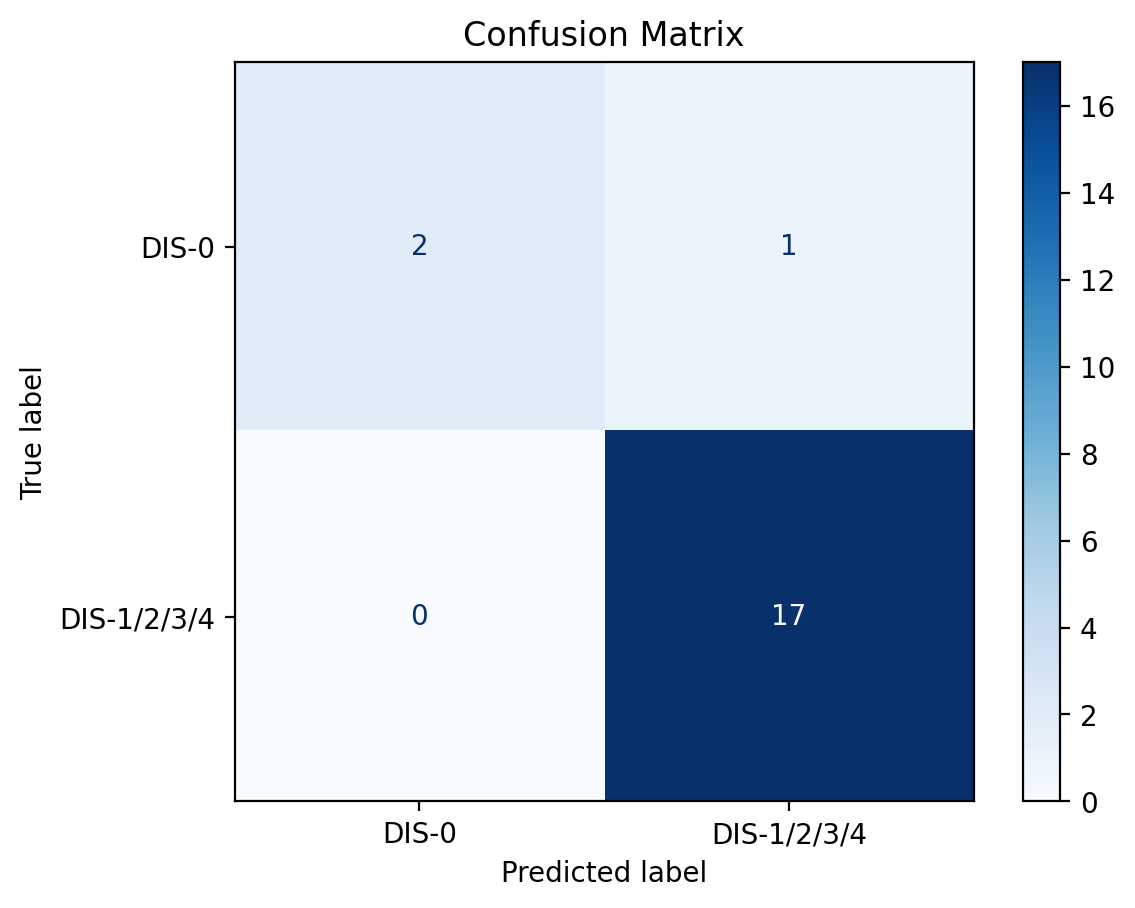

In [10]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [18]:
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

       DIS-0       1.00      0.67      0.80         3
 DIS-1/2/3/4       0.94      1.00      0.97        17

    accuracy                           0.95        20
   macro avg       0.97      0.83      0.89        20
weighted avg       0.95      0.95      0.95        20



#### Predict the Dystonia Amplitude Scores

In [20]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Dystonia-Amplitude'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  16:05:01 29/05/2023
STC train estimate  16:05:33 29/05/2023
STC weight = 0.6949696434761167
DrCIF  16:05:55 29/05/2023
DrCIF train estimate  16:06:00 29/05/2023
DrCIF weight = 0.4656965919933105
Arsenal  16:06:30 29/05/2023
Arsenal train estimate  16:06:46 29/05/2023
Arsenal weight = 0.5166864844679657
TDE  16:07:09 29/05/2023
TDE train estimate  16:07:09 29/05/2023
TDE weight = 0.5717532455930331


Create the confusion matrix

Confusion Matrix
[[ 2  1]
 [ 0 17]]


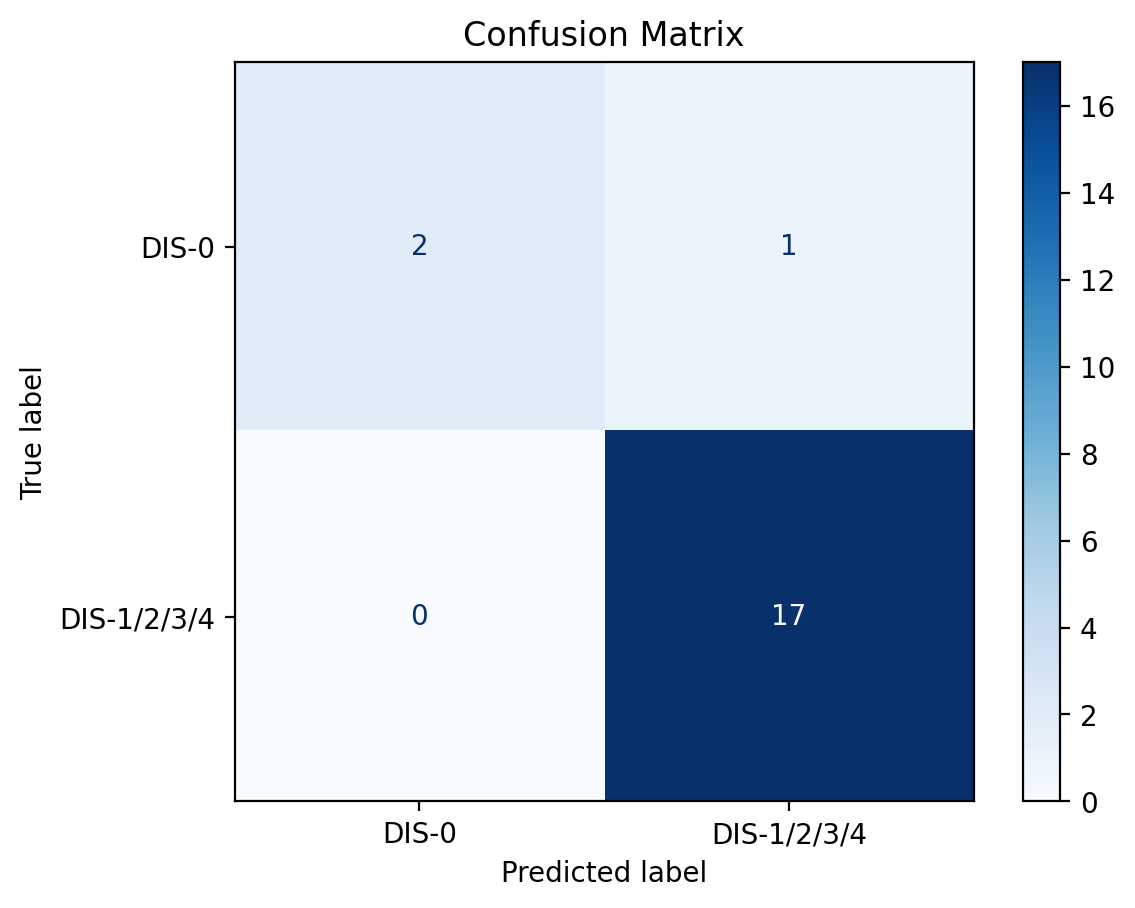

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [22]:
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

       DIS-0       1.00      0.67      0.80         3
 DIS-1/2/3/4       0.94      1.00      0.97        17

    accuracy                           0.95        20
   macro avg       0.97      0.83      0.89        20
weighted avg       0.95      0.95      0.95        20



#### Predict the Choreoathetosis Duration Scores

In [23]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Choreoathetosis-Duration'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  16:08:46 29/05/2023
STC train estimate  16:09:24 29/05/2023
STC weight = 0.18090630036342067
DrCIF  16:09:45 29/05/2023
DrCIF train estimate  16:09:49 29/05/2023
DrCIF weight = 0.15796492472511178
Arsenal  16:10:19 29/05/2023
Arsenal train estimate  16:10:35 29/05/2023
Arsenal weight = 0.26486491436208415
TDE  16:10:56 29/05/2023
TDE train estimate  16:10:56 29/05/2023
TDE weight = 0.33515125553439284


Create the confusion matrix

Confusion Matrix
[[ 0  5]
 [ 1 14]]


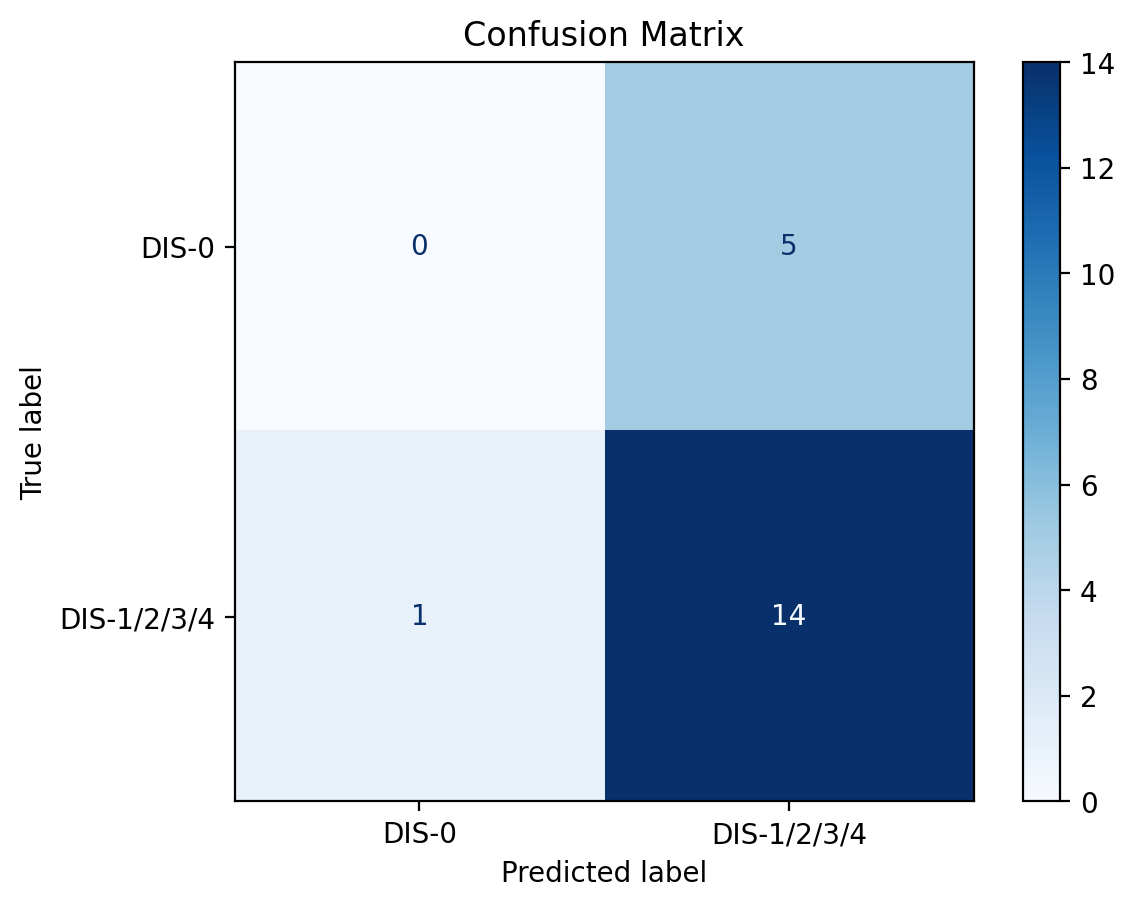

In [24]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [25]:
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

       DIS-0       0.00      0.00      0.00         5
 DIS-1/2/3/4       0.74      0.93      0.82        15

    accuracy                           0.70        20
   macro avg       0.37      0.47      0.41        20
weighted avg       0.55      0.70      0.62        20



#### Predict the Choreoathetosis Amplitude Scores

In [26]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Choreoathetosis-Amplitude'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  16:12:40 29/05/2023
STC train estimate  16:13:18 29/05/2023
STC weight = 0.18090630036342067
DrCIF  16:13:40 29/05/2023
DrCIF train estimate  16:13:45 29/05/2023
DrCIF weight = 0.15796492472511178
Arsenal  16:14:15 29/05/2023
Arsenal train estimate  16:14:31 29/05/2023
Arsenal weight = 0.26486491436208415
TDE  16:14:53 29/05/2023
TDE train estimate  16:14:53 29/05/2023
TDE weight = 0.33515125553439284


Create the confusion matrix

Confusion Matrix
[[ 0  5]
 [ 1 14]]


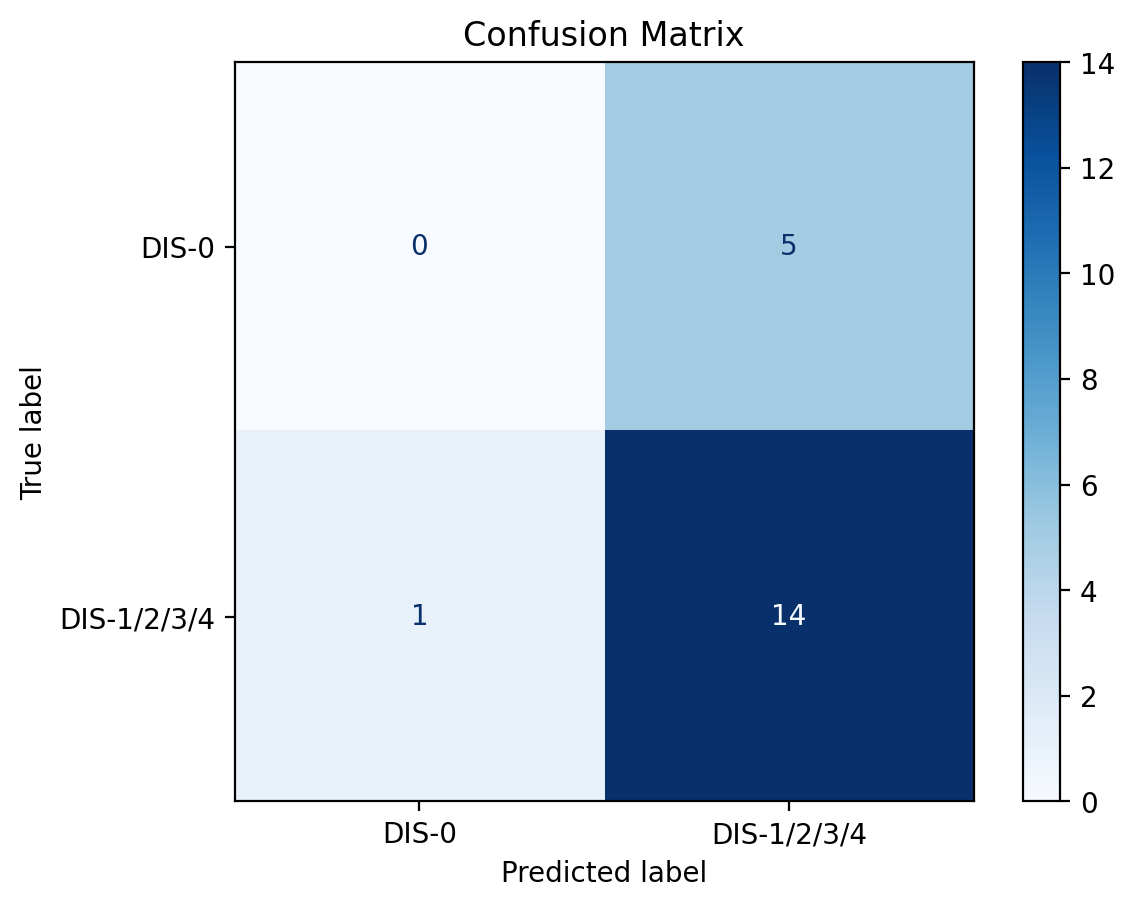

In [27]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [28]:
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

       DIS-0       0.00      0.00      0.00         5
 DIS-1/2/3/4       0.74      0.93      0.82        15

    accuracy                           0.70        20
   macro avg       0.37      0.47      0.41        20
weighted avg       0.55      0.70      0.62        20

